> # Neural Network Basic - Week3 과제 - 19기 김은지


## Import Library

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist

## Load Dataset
- MNIST 

In [2]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [3]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [4]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        z = np.exp(-x) # e^(-x)를 z로 치환
        sigmoid = 1 / (1 + z) 
        return sigmoid
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
        res = x + (1 - x)
        return res

In [5]:

class relu:
    # relu 함수를 작성하세요
    def forward(x):
        return np.maximum(0, x) # 두 값 중 큰 값 반환하는 함수. 입력 x가 0이 넘으면 활성화, 0보다 작으면 무조건 비활성화
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        return np.where(x > 0 , 1, 0) # 0보다 크면 1, 0보다 작거나 같으면 0이므로 np.where 함수를 이용하여 구현

In [6]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [7]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [8]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [9]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr # learning rate, 가중치 업데이트할 때 쓰이는 학습률
        self.epoch = epoch  # train set에 포함된 모든 데이터들이 한번씩 모델에 통과한 횟수
        self.batch_size = batch_size # 연산 한 번에 들어가는 데이터의 크기
        self.loss_function = cross_entropy  # 모델의 손실 함수를 cross entropy로 지정
        self.layers = []  # 신경망 모델에 쌓을 레이어 층들
        self.activations = [softmax] # 활성화 함수를 softmax로 지정
        self.nodes = [] # 레이어 층에 포함되는 노드들
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) # 레이어 추가
        if not self.nodes: # 노드가 비어있다면
            self.nodes.append(np.zeros(Layer.input_size)) # 입력된 input size 만큼 노드를추가
        self.nodes.append(np.zeros(Layer.output_size)) # 노드가 비어있지 않다면 output_size만큼 노드를 추가
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop()  # activation 리스트 중 가장 마지막 요소에 속하는 활성화 함수를 tmp에 임시 보관
        self.activations.append(Activation) # 인자로 받은 추가할 활성화 함수를 activation 리스트에 요소로 추가함
        self.activations.append(tmp) # tmp에 임시 보관했던 활성화함수를 activation 리스트의 마지막 요소에 추가하여 다시 마지막 요소가 되게끔 함.
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy() # 첫번재 노드를 X로 초기화함
        output = X.copy() # output에 X의 값을 복사해놓음.
        for i in range(len(self.layers)):
            Layer = self.layers[i] # i번째 레이어를 Layer로 지정
            Activation = self.activations[i]  # i번째 활성화 함수를 현재 활성화 함수로 지정
            output = np.dot(self.nodes[i], Layer.weight)  # i번째 노드의 값과 가중치의 값을 행렬곱하여 output에 저장
            output = output+ Layer.bias  # i번째 노드와 가중치의 값의 행렬곱에 bias를 더함.
            output = Activation.forward(output)  # 행렬곱에 bias를 더한 값에 활성화 함수를 적용함.
            self.nodes[i+1] = output  # 이를 i+1(다음)노드의 값으로 지정
        return output   # 연산 결과를 반환
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): # 역전파함수이므로 (len(self.layers) - 1)부터 0까지 거꾸로 for문 수행.
            a = self.nodes[i+1] # i+1(이전)노드의 값을 a로 지정
            Layer = self.layers[i] # i번째 레이어를 Layer로 지정
            Activation = self.activations[i] # i번째 활성화함수를 현재 활성화 함수로 지정
            
            if i+1 == len(self.layers): # 첫번째 레이어일 경우
                error = Activation.backward(output, y) # 역전파 함수에 output과 y값을 인자로 지정
            else: # 거꾸로 층별로 error 계산 
                error *= Activation.backward(a) 
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0] # error와 i번째 노드의 값을 행렬곱하여 learning rate를 곱하고 데이터의 크기만큼 나눠준 값으로 가중치 업데이트해줌.
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]  # error의 값에서 첫번째 괄호가 사라졌을 때 남은 원소가 하나로 더해짐. 그 값에 learning rate를 곻밯고 데이터의 크기만큼 나눠준 값으로 bias 업데이트해줌.
            error = np.dot(error, Layer.weight.T)  # error는 다시 현재 error의 값과 가중치를 행렬곱한 값으로 업데이트해줌.
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1)  # output에서 행별로(각 데이터별로) 각 클래스에 대해 예측한 확률 중 최대 확률에 해당하는 인덱스를 pre_p에 저장
        return np.sum(pre_p==y)/y.shape[0] # 예측한 인덱스(클래스)와 실제 클래스가 같은 데이터의 개수를 전체 데이터의 개수로 나눠 Accuracy 계산 및 반환
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0] # 데이터의 크기
        for i in range(self.epoch): # epoch 수만큼 반복
            for j in range(N//self.batch_size): # 한 번 학습할 때 batch size만큼 수행
                batch_mask = np.random.choice(N, self.batch_size) # 랜덤으로 학습에 이용할 batch 인덱스 batch_mask에 지정
                X_batch = X[batch_mask]  # batch_mask로 지정된 인덱스를 이용하여 X에서 학습할 데이터를 추출한 다음 X_batch에 저장
                y_batch = y[batch_mask]  # batch_mask로 지정된 인덱스를 이용하여 y에서 학습할 데이터를 추출한 다음 y_batch에 저장
                output = self._forward(X_batch)  # batch 데이터에 대해 순전파 학습 수행
                self._backward(X_batch, output, y_batch)  # batch 데이터에 대해 역전파 학습 수행
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X)  # validation X 데이터에 대해 순전파 수행
            history["val_acc"].append(self._accuracy(output, val_y))  # validation X 데이터에 대한 순전파 수행 결과와 실제 y데이터를 비교하여 Accuracy 계산 후 val_acc에 저장
            history["val_loss"].append(sum(self.loss_function(output, val_y))) # validation X 데이터에 대한 순전파 수행 결과와 실제 y데이터를 비교하여 loss 계산 후 val_loss에 저장
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [10]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=200, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [11]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [12]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1543
0 test loss     : 23015.980454002532
10 test accuracy : 0.1195
10 test loss     : 22764.485640496096
20 test accuracy : 0.1946
20 test loss     : 21677.07435062503
30 test accuracy : 0.3032
30 test loss     : 19188.308274446714
40 test accuracy : 0.4279
40 test loss     : 17239.3122509762
50 test accuracy : 0.5865
50 test loss     : 13705.054831850866
60 test accuracy : 0.7001
60 test loss     : 10626.927040260316
70 test accuracy : 0.7648
70 test loss     : 8716.905279878043
80 test accuracy : 0.8045
80 test loss     : 7423.969140226732
90 test accuracy : 0.8277
90 test loss     : 6505.391683056242
100 test accuracy : 0.8462
100 test loss     : 5823.222914478656
110 test accuracy : 0.86
110 test loss     : 5316.751902338531
120 test accuracy : 0.868
120 test loss     : 4937.622624387774
130 test accuracy : 0.8761
130 test loss     : 4655.816292369132
140 test accuracy : 0.8821
140 test loss     : 4439.69326992318
150 test accuracy : 0.8859
150 test loss     : 

In [13]:
# 1.
nn = CustomNet(lr=0.005, epoch=200, batch_size=300)
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [14]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 22940.038469778716
10 test accuracy : 0.1852
10 test loss     : 21864.939579837435
20 test accuracy : 0.3158
20 test loss     : 19659.88962695787
30 test accuracy : 0.5312
30 test loss     : 15229.58596362257
40 test accuracy : 0.7161
40 test loss     : 10364.556313655195
50 test accuracy : 0.7768
50 test loss     : 7973.138025330704
60 test accuracy : 0.8029
60 test loss     : 6706.859591198887
70 test accuracy : 0.8234
70 test loss     : 5953.477556933433
80 test accuracy : 0.8398
80 test loss     : 5422.352479424038
90 test accuracy : 0.8578
90 test loss     : 5008.257878502572
100 test accuracy : 0.8686
100 test loss     : 4683.619559917539
110 test accuracy : 0.876
110 test loss     : 4435.052678847177
120 test accuracy : 0.881
120 test loss     : 4238.434232097105
130 test accuracy : 0.8872
130 test loss     : 4084.1052764746705
140 test accuracy : 0.8901
140 test loss     : 3965.2718990056137
150 test accuracy : 0.8935
150 test loss    

In [16]:
# 2.
nn = CustomNet(lr=0.01, epoch=200, batch_size=300)
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [17]:
history_2 = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1705
0 test loss     : 22799.394758582665
10 test accuracy : 0.337
10 test loss     : 17912.25734268908
20 test accuracy : 0.7076
20 test loss     : 10274.183512052847
30 test accuracy : 0.8365
30 test loss     : 6150.8732918108035
40 test accuracy : 0.8732
40 test loss     : 4717.7046946184355
50 test accuracy : 0.8897
50 test loss     : 4059.2568106687695
60 test accuracy : 0.8986
60 test loss     : 3693.555443625253
70 test accuracy : 0.9034
70 test loss     : 3464.881981810225
80 test accuracy : 0.9074
80 test loss     : 3318.7102773950987
90 test accuracy : 0.9093
90 test loss     : 3212.891715546466
100 test accuracy : 0.9117
100 test loss     : 3130.6134473209427
110 test accuracy : 0.9133
110 test loss     : 3071.06467971212
120 test accuracy : 0.914
120 test loss     : 3027.937914830588
130 test accuracy : 0.9138
130 test loss     : 2996.2972038134994
140 test accuracy : 0.9148
140 test loss     : 2965.5802370191695
150 test accuracy : 0.9161
150 test loss 

In [19]:
# 3.
nn = CustomNet(lr=0.005, epoch=200, batch_size=300)
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [20]:
history_3 = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 23006.879963443094
10 test accuracy : 0.1246
10 test loss     : 22416.729784906736
20 test accuracy : 0.3339
20 test loss     : 19859.711165278943
30 test accuracy : 0.4811
30 test loss     : 16128.769259961882
40 test accuracy : 0.6192
40 test loss     : 12200.195641525124
50 test accuracy : 0.7209
50 test loss     : 9885.78033537415
60 test accuracy : 0.765
60 test loss     : 8321.006506420947
70 test accuracy : 0.8023
70 test loss     : 7199.515071313425
80 test accuracy : 0.8258
80 test loss     : 6362.259462675005
90 test accuracy : 0.8391
90 test loss     : 5792.935245057819
100 test accuracy : 0.8484
100 test loss     : 5415.327529140795
110 test accuracy : 0.8531
110 test loss     : 5173.648550479482
120 test accuracy : 0.8565
120 test loss     : 5016.976753157288
130 test accuracy : 0.8579
130 test loss     : 4908.653375419583
140 test accuracy : 0.8592
140 test loss     : 4807.57307536174
150 test accuracy : 0.8621
150 test loss     

lr=0.005, epoch=200, batch_size=300 일 때 Accuracy = 0.9169로 가장 높았다.

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

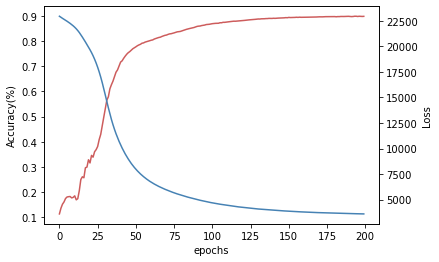

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(200), history['val_acc'], color='indianred')
plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
ax2 = ax.twinx()
ax2.plot(range(200), history['val_loss'], color='steelblue')
plt.ylabel('Loss')

plt.show()

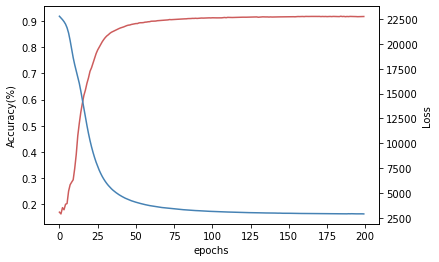

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(200), history_2['val_acc'], color='indianred')
plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
ax2 = ax.twinx()
ax2.plot(range(200), history_2['val_loss'], color='steelblue')
plt.ylabel('Loss')

plt.show()

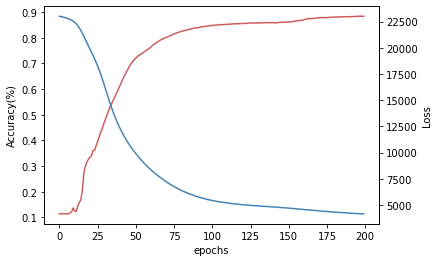

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(200), history_3['val_acc'], color='indianred')
plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
ax2 = ax.twinx()
ax2.plot(range(200), history_3['val_loss'], color='steelblue')
plt.ylabel('Loss')

plt.show()